In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from timeit import default_timer as timer

import torch
import torch.nn as nn
import torch.func as func
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.metrics import bleu_score
import torchtext.data
from torch.nn.utils.rnn import pad_sequence
import spacy

import math
from copy import deepcopy
import matplotlib.pyplot as plt
import os

import requests
from datasets import load_dataset
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [26]:
DEVICE="cpu"
torch.manual_seed(1)
np.random.seed(1)

In [40]:
def f(x):
    return torch.sum(x)

a=torch.tensor([[[1,2],[3,4]],
                [[5,6],[7,8]]])
b=func.vmap(f,2)(a)
print(b)

tensor([16, 20])


In [32]:
class Attention(nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super(Attention,self).__init__()
        self.nhead = nhead
        self.d_model = d_model
        self.d_k = d_model//nhead
        self.W_q = nn.Linear(self.d_model, self.d_model)
        self.W_k = nn.Linear(self.d_model, self.d_model)
        self.W_v = nn.Linear(self.d_model, self.d_model)
        self.W_o = nn.Linear(self.d_model, self.d_model)
        self.elu = nn.ELU()
        
    def forward(self, Q, K, V, pad_mask=None, attn_mask=None):
        Q=self.W_q(Q)
        K=self.W_k(K)
        V=self.W_v(V)
        
        Q = Q.reshape(Q.shape[0], Q.shape[1], self.nhead, self.d_k).transpose(0, 2)
        K = K.reshape(K.shape[0], K.shape[1], self.nhead, self.d_k).transpose(0, 2)
        V = V.reshape(V.shape[0], V.shape[1], self.nhead, self.d_k).transpose(0, 2)
        #shape=(heads, batches, seqlen, dims)
        
        '''
        X = torch.empty(Q.shape).to(DEVICE)
        
        def phi(x):
            return self.elu(x)+1
        
        
        for head in range(Q.shape[0]):
            for batch in range(Q.shape[1]):
                for i in range(Q.shape[2]):
                    numer=0
                    denom=torch.zeros(V.shape[3]).to(DEVICE)
                    for j in range(V.shape[2]):
                        if not(
                            ((pad_mask is not None) and (pad_mask[batch,j])) 
                            or ((attn_mask is not None) and (attn_mask[i,j]))
                        ):
                            numer+=torch.dot(phi(K[head,batch,j]), V[head,batch,j])
                            denom+=V[head,batch,j]
                    phiQ=phi(Q[head,batch,i])
                    X[head,batch,i]=phiQ*numer/torch.dot(phiQ,denom)
                            
        '''
        X = torch.matmul(Q, K.transpose(2,3)) / math.sqrt(self.d_k)
        if (pad_mask is not None):
            #shape=(batches, seqlen)
            X=X.masked_fill(pad_mask.reshape(1,pad_mask.shape[0],1,pad_mask.shape[1]), -1.0e10)
        
        if (attn_mask is not None):
            #shape=(seqlen, seqlen)
            X=X.masked_fill(attn_mask.reshape(1,1,attn_mask.shape[0],attn_mask.shape[1]), -1.0e10)
        
        X = torch.softmax(X,dim=3)
        X = torch.matmul(X, V)
        #'''
        X = X.transpose(0,2)
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2]*X.shape[3])
        X = self.W_o(X)
        return X
    
class Encoder(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout):
        super(Encoder, self).__init__()
        self.mha = Attention(d_model, nhead, dropout)
        #self.mha = nn.MultiheadAttention(d_model,nhead)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.ReLU(),
            nn.Linear(d_ff,d_model)
        )
        
        self.norm1=nn.LayerNorm(d_model)
        self.norm2=nn.LayerNorm(d_model)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self, X, src_pad_mask=None):
        sub_X = self.mha(X,X,X,src_pad_mask)
        X=self.norm1(X+self.dropout(sub_X))
        sub_X=self.feed_forward(X)
        X=self.norm2(X+self.dropout(sub_X))
        return X

class Decoder(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout):
        super(Decoder, self).__init__()
        self.mha = Attention(d_model, nhead, dropout)
        self.masked_mha = Attention(d_model, nhead, dropout)
        #self.mha = nn.MultiheadAttention(d_model,nhead)
        #self.masked_mha = nn.MultiheadAttention(d_model,nhead)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.ReLU(),
            nn.Linear(d_ff,d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X, memory, src_pad_mask=None, trg_pad_mask=None):
        sub_X=self.masked_mha(X,X,X, trg_pad_mask, 
                              attn_mask=(1-torch.tril(torch.ones(X.shape[0],X.shape[0]))).bool().to(DEVICE))
        X=self.norm1(X+self.dropout(sub_X))
        sub_X = self.mha(X, memory, memory, src_pad_mask)
        X=self.norm2(X+self.dropout(sub_X))
        sub_X = self.feed_forward(X)
        X=self.norm3(X+self.dropout(sub_X))
        return X

class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=1000):
        super(PositionalEncoding, self).__init__()
        PE=torch.empty((max_len,d_model))
        pos=torch.arange(max_len).reshape((max_len,1))
        wave_len=10000**(torch.arange(0,d_model,step=2)/d_model)
        PE[:,0::2]=torch.sin(pos*wave_len)
        PE[:,1::2]=torch.cos(pos*wave_len)
        self.register_buffer('PE', PE) #to run on gpu
    def forward(self, X):
        return X+self.PE[0:len(X),].reshape((len(X),1,X.shape[2]))


class Transformer(nn.Module):
    def __init__(self,src_vocab_size,trg_vocab_size,
                 n_encoders=6,n_decoders=6,d_model=512,nhead=8,d_ff=2048,dropout= 0.1):
        super(Transformer, self).__init__()
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.trg_tok_emb = nn.Embedding(trg_vocab_size, d_model)
        self.encoder = nn.ModuleList([deepcopy(Encoder(
            d_model,nhead,d_ff,dropout
        )) for i in range(n_encoders)])
        self.decoder = nn.ModuleList([deepcopy(Decoder(
            d_model,nhead,d_ff,dropout
        )) for i in range(n_decoders)])
        self.generator = nn.Linear(d_model, trg_vocab_size)
        self.positional_encoding = PositionalEncoding(d_model)

    def forward(self,src,trg):
        memory = self.src_tok_emb(src)
        memory=self.positional_encoding(memory)
        output = self.trg_tok_emb(trg)
        output=self.positional_encoding(output)
        src_pad_mask=(src == PAD_IDX).transpose(0,1)
        trg_pad_mask=(trg == PAD_IDX).transpose(0,1)
        
        
        for encoder in self.encoder:
            memory=encoder(memory,src_pad_mask)
        for decoder in self.decoder:
            output = decoder(output,
                             memory,
                             src_pad_mask,trg_pad_mask)

        return self.generator(output)
    
    def encode(self,src):
        memory = self.src_tok_emb(src)
        memory=self.positional_encoding(memory)
        for encoder in self.encoder:
            memory=encoder(memory)
        return memory

    def decode(self,trg,memory):
        output = self.trg_tok_emb(trg)
        output=self.positional_encoding(output)
        for decoder in self.decoder:
            output = decoder(output,
                             memory)
        return output

In [16]:
#define constants
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3 #special token indices

In [17]:
#downloaded from https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench
dat=pd.read_csv("eng_-french.csv") 
dat_en=dat["English words/sentences"].to_numpy()[0:1000]
dat_fr=dat["French words/sentences"].to_numpy()[0:1000]
print(len(dat_en))

#get tokenizers
spacy_en = get_tokenizer('spacy', language='en_core_web_sm')
spacy_fr = get_tokenizer('spacy', language='fr_core_news_sm')

1000


In [18]:
#get vocabularies and text tokenizers
def get_vocab_text(dat,tokenizer):
    counter = Counter()
    for s in dat:
        counter.update(list(tokenizer(s)))
    vocab = build_vocab_from_iterator([counter], specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    vocab.set_default_index(vocab['<unk>'])
    def text_tok(text):
        str_tokens=tokenizer(text)
        int_tokens=vocab(str_tokens)
        return torch.cat((torch.tensor([BOS_IDX]),torch.tensor(int_tokens),torch.tensor([EOS_IDX])))
    return vocab,text_tok
    
    

In [19]:
vocab_en,text_en=get_vocab_text(dat_en,spacy_en)
print(text_en("hello world!"))
vocab_fr,text_fr=get_vocab_text(dat_fr,spacy_fr)


tensor([  2, 353,   0,   6,   3])


In [20]:
class CustomDataset(Dataset):
    def __init__(self, src, trg):
        super().__init__()
        self.src = src
        self.trg = trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.trg[idx]

def get_dataloader(dat_src,dat_trg,text_tok_src,text_tok_trg,train_split=0.8):
    dat_st=CustomDataset(dat_src,dat_trg)
    train_data, val_data = random_split(dat_st, [train_split, 1-train_split])
    def collate_fn(batch):
        src_batch, trg_batch = [], []
        for src,trg in batch:
            src_batch.append(text_tok_src(src))
            trg_batch.append(text_tok_trg(trg))
        return pad_sequence(src_batch, padding_value=PAD_IDX), pad_sequence(trg_batch, padding_value=PAD_IDX)

    train_dataloader = DataLoader(train_data, batch_size=16, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_data, batch_size=16, collate_fn=collate_fn)
    return train_dataloader, val_dataloader

In [21]:
train_dataloader, val_dataloader = get_dataloader(dat_en,dat_fr,text_en,text_fr)

In [22]:
def train(transformer, train_dataloader, val_dataloader,  criterion, optimizer, plt_title, epochs=5):
    start=timer()
    train_loss=np.zeros(epochs)
    val_loss=np.zeros(epochs)
    for epoch in range(epochs):
        #print(f"epoch {epoch}")
        transformer.train()

        for src, trg in train_dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)
            out = transformer(src, trg[:-1, :])
            out = out.reshape(out.shape[0]*out.shape[1],out.shape[2])
            loss = criterion(out, trg[1:, :].flatten())
            optimizer.zero_grad()
            loss.backward()
            train_loss[epoch] += loss.item()
            optimizer.step()
        #print(f"training loss: {train_loss/len(list(train_dataloader))}")
        #print(f"time: {timer()-start}")

        transformer.eval()

        for src, trg in val_dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)
            out = transformer(src, trg[:-1, :])
            out = out.reshape(out.shape[0]*out.shape[1],out.shape[2])
            loss = criterion(out, trg[1:, :].flatten())
            val_loss[epoch] += loss.item()

        #print(f"validation loss: {val_loss/len(list(val_dataloader))}")
        print(f"time: {timer()-start}")
    
    train_loss/=len(list(train_dataloader))
    val_loss/=len(list(val_dataloader))
    print(train_loss)
    print(val_loss)
    #'''
    plt.plot(range(epochs),train_loss,label="training")
    plt.plot(range(epochs),val_loss,label="validation")
    plt.title(plt_title)
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim([0,0.1+np.max([train_loss,val_loss])])
    plt.show()
    plt.clf()
    #'''

In [33]:
transformer = Transformer(len(vocab_en), len(vocab_fr),1,1, 512, 8,  2048, 0.1).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters())
train(transformer, train_dataloader,val_dataloader,
      criterion, optimizer, "a")

KeyboardInterrupt: 

In [14]:
def translate(model, src):
    src=text_en(src)
    src=src.reshape(len(src),1).to(DEVICE)
    trg=[BOS_IDX]
    memory = model.encode(src)
    for i in range(len(src)+10):
        out=model.decode(torch.tensor(trg).reshape(len(trg),1).to(DEVICE), memory)
        prob=model.generator(out[i])
        next_word=torch.argmax(prob)
        trg+=[next_word]
        if next_word==EOS_IDX:
            break
    trg=vocab_fr.lookup_tokens(trg)
    return trg[1:(len(trg)-1)]

def evaluate(model, test_src, test_trg, samp_size, max_n, verbose=False):
    samp_size = np.min((samp_size,len(test_src)))
    score=np.empty(samp_size)
    samp=np.random.choice(len(test_src), samp_size, replace=False)
    for i in range(samp_size):
        idx=samp[i]
        pred=translate(model,test_src[idx])
        if (verbose):
            print(test_trg[idx])
            print(" ".join(pred))
        score[i]=bleu_score([pred], [[spacy_fr(test_trg[idx])]],max_n=max_n,weights=np.full(max_n,1/max_n))
    return np.mean(score),np.std(score)


In [35]:
#downloaded from https://huggingface.co/datasets/Nicolas-BZRD/Parallel_Global_Voices_English_French
dat1=pd.read_parquet("eng_-french2.parquet")

In [36]:
dat1_en=dat1["en"].to_numpy()
dat1_fr=dat1["fr"].to_numpy()

In [37]:
def tune_layers(n_encoders,n_decoders):
    transformer = Transformer(len(vocab_en), len(vocab_fr),n_encoders,n_decoders, 512, 8,  2048, 0.1).to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    optimizer = torch.optim.Adam(transformer.parameters())
    train(transformer, train_dataloader,val_dataloader,
          criterion, optimizer, "{} encoders, {} decoders".format(n_encoders,n_decoders))
    print(evaluate(transformer, dat_en, dat_fr, 1000, 4))
    print(evaluate(transformer, dat1_en, dat1_fr, 1000, 4))
    return transformer

time: 221.58196280000266
time: 419.205575400003
time: 621.7796546000027
time: 825.2778282000072
time: 1034.022650400002
[2.95854954 2.09369774 1.76436064 1.54349631 1.39737407]
[2.37184895 2.06233671 1.91164701 1.85753546 1.79414701]


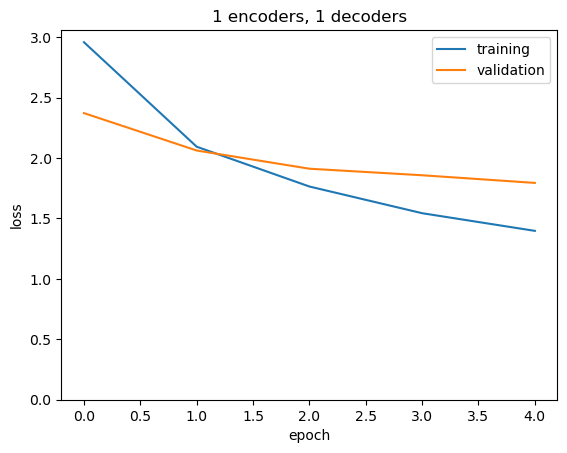

(0.22902752559405745, 0.33692915512524246)
(0.011329959106784734, 0.06807507226134787)


<Figure size 640x480 with 0 Axes>

In [38]:
transformer=tune_layers(1,1)

In [27]:
translate(transformer,"hello")

NameError: name 'transformer' is not defined

In [ ]:
tune_layers(2,2)

In [ ]:
tune_layers(3,3)

In [ ]:
from googletrans import Translator

In [ ]:
def evaluate(model, test_src, test_trg, samp_size, max_n, verbose=False):
    samp_size = np.min((samp_size,len(test_src)))
    score=np.empty(samp_size)
    samp=np.random.choice(len(test_src), samp_size, replace=False)
    for i in range(samp_size):
        idx=samp[i]
        pred=translate(model,test_src[idx])
        if (verbose):
            print(test_trg[idx])
            print(" ".join(pred))
        score[i]=bleu_score([pred], [spacy_fr(test_trg[idx])],max_n=max_n,weights=np.full(max_n,1/max_n))
    return np.mean(score),np.std(score)


In [ ]:
def evaluate_baseline(pred, test_trg, max_n, verbose=False):
    samp_size = len(pred)
    for i in range(samp_size):
        score[i]=bleu_score([pred[i]], [spacy_fr(test_trg[i])],max_n=max_n,weights=np.full(max_n,1/max_n))
    return np.mean(score),np.std(score)


In [ ]:
DEVICE="cuda"
torch.manual_seed(1)
np.random.seed(1)

In [ ]:
transformer = Transformer(len(vocab_en), len(vocab_fr),1,1, 512, 8,  2048, 0.1).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters())
train(transformer, criterion, optimizer, "1 encoders, 1 decoders")
print(evaluate(transformer, dat_en, dat_fr, 1000, 1))
print(evaluate(transformer, dat_en, dat_fr, 1000, 2))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 1))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 2))
tf0=transformer

In [ ]:
transformer = Transformer(len(vocab_en), len(vocab_fr),1,1, 512, 8,  2048, 0.1, void_mha=True).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters())
train(transformer, criterion, optimizer, "No multi-head attention")
print(evaluate(transformer, dat_en, dat_fr, 1000, 1))
print(evaluate(transformer, dat_en, dat_fr, 1000, 2))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 1))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 2))
tf1=transformer

In [ ]:
transformer = Transformer(len(vocab_en), len(vocab_fr),1,1, 512, 8,  2048, 0.1, void_mask=True).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters())
train(transformer, criterion, optimizer, "No masks")
print(evaluate(transformer, dat_en, dat_fr, 1000, 1))
print(evaluate(transformer, dat_en, dat_fr, 1000, 2))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 1))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 2))
tf2=transformer

In [ ]:
transformer = Transformer(len(vocab_en), len(vocab_fr),1,1, 512, 8,  2048, 0.1, void_pe=True).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters())
train(transformer, criterion, optimizer, "No positional encoding")
print(evaluate(transformer, dat_en, dat_fr, 1000, 1))
print(evaluate(transformer, dat_en, dat_fr, 1000, 2))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 1))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 2))
tf3=transformer

In [ ]:
transformer = Transformer(len(vocab_en), len(vocab_fr),1,1, 512, 8,  2048, 0.1, void_ff=True).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters())
train(transformer, criterion, optimizer, "No feed-forward layers")
print(evaluate(transformer, dat_en, dat_fr, 1000, 1))
print(evaluate(transformer, dat_en, dat_fr, 1000, 2))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 1))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 2))
tf4=transformer

In [ ]:
transformer = Transformer(len(vocab_en), len(vocab_fr),1,1, 512, 8,  2048, 0.1, void_ann=True).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters())
train(transformer, criterion, optimizer, "No residual connection+layer normalization")
print(evaluate(transformer, dat_en, dat_fr, 1000, 1))
print(evaluate(transformer, dat_en, dat_fr, 1000, 2))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 1))
print(evaluate(transformer, dat1_en, dat1_fr, 1000, 2))
tf5=transformer

In [ ]:
dat3_en=["A transformer is a deep learning architecture developed by Google and based on the multi-head attention mechanism, proposed in a 2017 paper \"Attention Is All You Need\".",

"Text is converted to numerical representations called tokens, and each token is converted into a vector via looking up from a word embedding table.",

"At each layer, each token is then contextualized within the scope of the context window with other (unmasked) tokens via a parallel multi-head attention mechanism allowing the signal for key tokens to be amplified and less important tokens to be diminished.",

"The transformer paper, published in 2017, is based on the softmax-based attention mechanism proposed by Bahdanau et. al. in 2014 for machine translation, and the Fast Weight Controller, similar to a transformer, proposed in 1992.",

"Transformers have the advantage of having no recurrent units, and thus requires less training time than previous recurrent neural architectures, such as long short-term memory (LSTM), and its later variation has been prevalently adopted for training large language models (LLM) on large (language) datasets, such as the Wikipedia corpus and Common Crawl.",

"This architecture is now used not only in natural language processing and computer vision, but also in audio and multi-modal processing.",

"It has also led to the development of pre-trained systems, such as generative pre-trained transformers (GPTs) and BERT (Bidirectional Encoder Representations from Transformers)."]

dat3_fr=["Un transformateur est une architecture d’apprentissage profond développée par Google et basée sur le mécanisme d’attention multi-têtes, proposé dans un article de 2017 \"Attention est tout ce dont vous avez besoin\".",

"Le texte est converti en représentations numériques appelées jetons, et chaque jeton est converti en vecteur en remontant vers le haut à partir d’une table d’intégration de mots.",

"À chaque couche, chaque jeton est ensuite contextualisé dans le cadre de la fenêtre contextuelle avec d’autres jetons (non masqués) via un mécanisme d’attention multi-têtes parallèle permettant d’amplifier le signal pour les jetons clés et de diminuer les jetons moins importants.",

"L’article sur le transformateur, publié en 2017, est basé sur le mécanisme d’attention basé sur softmax proposé par Bahdanau et al. en 2014 pour la traduction automatique, et le contrôleur de poids rapide, similaire à un transformateur, proposé en 1992.",

"Les transformateurs ont l’avantage de ne pas avoir d’unités récurrentes, et nécessitent donc moins de temps d’entraînement que les architectures neuronales récurrentes précédentes, telles que la mémoire à long terme et à court terme (LSTM), et sa variante ultérieure a été largement adoptée pour l’entraînement de grands modèles de langage (LLM) sur de grands ensembles de données (de langage), tels que le corpus Wikipédia et le Common Crawl.",

"Cette architecture est aujourd’hui utilisée non seulement dans le traitement du langage naturel et la vision par ordinateur, mais aussi dans l’audio et le traitement multimodal.",

"Cela a également conduit au développement de systèmes pré-entraînés, tels que les transformateurs génératifs pré-entraînés (GPT) et BERT (Représentations bidirectionnelles d'encodeurs à partir de transformateurs)."]

In [ ]:
for transformer in [tf0,tf1,tf2,tf3,tf4,tf5]:
    print("*")
    print(evaluate(transformer, dat_en, dat_fr, 1000, 3))
    print(evaluate(transformer, dat_en, dat_fr, 1000, 4))

In [ ]:
for transformer in [tf0,tf1,tf2,tf3,tf4,tf5]:
    print("*")
    #print(evaluate(transformer, dat3_en, dat3_fr, 1000, 1))
    #print(evaluate(transformer, dat3_en, dat3_fr, 1000, 2))
    print(" ".join(translate(transformer, "Meet me at the hotel bar.")))
    print(" ".join(translate(transformer, "Money won't be a problem.")))
    print(" ".join(translate(transformer, "We met in a coffee shop near the campus.")))
    print(" ".join(translate(transformer, "Hey, what do you think you're doing?")))
    print(" ".join(translate(transformer, "They offered no explanation.")))


In [ ]:
dat2_en=["I am.","You are.","He is.","She is.","We are.","They are."]
dat2_fr=["Je suis.","Tu est.","Il est.","Elle est.","Nous sommes.","Ils sont."]
for transformer in [tf0,tf1,tf2,tf3,tf4,tf5]:
    print("*")
    print(evaluate(transformer, dat2_en, dat2_fr, 1000, 1, True))


In [ ]:
torch.manual_seed(2)
np.random.seed(2)
transformer32 = Transformer(len(vocab_en), len(vocab_fr),3,2, 512, 8,  2048, 0.1).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer32.parameters())
train(transformer32, criterion, optimizer, "3 encoders, 2 decoders")

transformer11 = Transformer(len(vocab_en), len(vocab_fr),1,1, 512, 8,  2048, 0.1).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer11.parameters())
train(transformer11, criterion, optimizer, "1 encoders, 1 decoders")

In [ ]:
samp=np.random.choice(len(dat_en), 5)
samp1=np.random.choice(len(dat1_en), 5)
dat2_en=["I am.","You are.","He is.","She is.","We are.","They are."]
dat2_fr=["Je suis.","Tu est.","Il est.","Elle est.","Nous sommes.","Ils sont."]
for i in samp:
    print(dat_en[i])
for i in samp1:
    print(dat1_en[i])
for i in dat2_en:
    print(i)
for i in samp:
    print(dat_fr[i])
for i in samp1:
    print(dat1_fr[i])
for i in dat2_fr:
    print(i)

In [ ]:
dat2_en=["I am.","You are.","He is.","She is.","We are.","They are."]
dat2_fr=["Je suis.","Tu est.","Il est.","Elle est.","Nous sommes.","Ils sont."]
for i in samp:
    print(dat_en[i])
for i in samp1:
    print(dat1_en[i])
for i in dat2_en:
    print(i)
for i in samp:
    print(dat_fr[i])
for i in samp1:
    print(dat1_fr[i])
for i in dat2_fr:
    print(i)

In [ ]:
for i in samp:
    print(" ".join(translate(transformer32,dat_en[i])))
for i in samp1:
    print(" ".join(translate(transformer32,dat1_en[i])))
for i in range(6):
    print(" ".join(translate(transformer32,dat2_en[i])))
# According to Google Translate, the output translates to:
'''
I am really happy .
I am really happy .
It's a good story .
I am really happy .
It was a little hot.
It was a little hot.
I am really happy .
I am really happy .
It was a little hot.
I am really happy .
It's a good story .
It's a good .
It's a good .
It's a good .
It's a good .
It's a good .
'''

In [ ]:
score=0
for i in samp:
    s=(bleu_score([translate(transformer32,dat_en[i])], [spacy_fr(dat_fr[i])],max_n=1,weights=np.full(1,1)))
    print(s)
    score+=s

for i in samp1:
    s=(bleu_score([translate(transformer32,dat1_en[i])], [spacy_fr(dat1_fr[i])],max_n=1,weights=np.full(1,1)))
    print(s)
    score+=s

for i in range(6):
    s=(bleu_score([translate(transformer32,dat2_en[i])], [spacy_fr(dat2_fr[i])],max_n=1,weights=np.full(1,1)))
    print(s)
    score+=s
print(score/16)

score=0
for i in samp:
    s=(bleu_score([translate(transformer32,dat_en[i])], [spacy_fr(dat_fr[i])],max_n=2,weights=np.full(2,1/2)))
    score+=s

for i in samp1:
    s=(bleu_score([translate(transformer32,dat1_en[i])], [spacy_fr(dat1_fr[i])],max_n=2,weights=np.full(2,1/2)))
    score+=s

for i in range(6):
    s=(bleu_score([translate(transformer32,dat2_en[i])], [spacy_fr(dat2_fr[i])],max_n=2,weights=np.full(2,1/2)))
    score+=s
print(score/16)

In [ ]:
for i in samp:
    print(" ".join(translate(transformer11,dat_en[i])))
for i in samp1:
    print(" ".join(translate(transformer11,dat1_en[i])))
for i in range(6):
    print(" ".join(translate(transformer11,dat2_en[i])))
# According to Google Translate, the output translates to:
'''
I can't force you to do this.
You think you're old, don't you?
How would you say such a thing?
I understand it, but I don't agree with it.
He's a good singer for a win.
The general calmed down because of my teeth.
He has news for the Tom is Crazy doc.
Without water, girls have girls at four o'clock.
Even the adults and let's see the French, it was last.
But later, Tom, the hours, the exams, I'm done.
I'm fussy.
You are devoid of that.
He's addicted.
She is caring.
We are drunk.
They are expensive.
'''

In [ ]:
score=0
for i in samp:
    s=(bleu_score([translate(transformer11,dat_en[i])], [spacy_fr(dat_fr[i])],max_n=1,weights=np.full(1,1)))
    print(s)
    score+=s

for i in samp1:
    s=(bleu_score([translate(transformer11,dat1_en[i])], [spacy_fr(dat1_fr[i])],max_n=1,weights=np.full(1,1)))
    print(s)
    score+=s

for i in range(6):
    s=(bleu_score([translate(transformer11,dat2_en[i])], [spacy_fr(dat2_fr[i])],max_n=1,weights=np.full(1,1)))
    print(s)
    score+=s
print(score/16)

score=0
for i in samp:
    s=(bleu_score([translate(transformer11,dat_en[i])], [spacy_fr(dat_fr[i])],max_n=2,weights=np.full(2,1/2)))
    score+=s

for i in samp1:
    s=(bleu_score([translate(transformer11,dat1_en[i])], [spacy_fr(dat1_fr[i])],max_n=2,weights=np.full(2,1/2)))
    score+=s

for i in range(6):
    s=(bleu_score([translate(transformer11,dat2_en[i])], [spacy_fr(dat2_fr[i])],max_n=2,weights=np.full(2,1/2)))
    score+=s
print(score/16)

In [ ]:
gt_en=["Je ne peux pas vous permettre de faire cela.",
"Tu me trouves moche, n'est-ce pas?",
"Comment oses-tu dire une chose pareille?",
"Je le comprends mais je ne suis tout de même pas d'accord.",
"C'est une excellente journée pour une randonnée.",
"Le modérateur était David Ignatius du Washington Post.",
"Il appartient à la tribu Mehsud, dans la région politiquement instable du Sud-Waziristan et dirige dans les 20 000 miliciens pro-talibans.",
"A cause du manque d'eau, les filles doivent marcher longtemps tout en transportant de lourds bidons d'eau.",
"Même le Ghana et le Laos nous ont surpassés l'an dernier.",
"Mais à partir du mardi 14 avril 2009, Neptune va progressivement se retirer de Lakhana Duang Muang pour se rapprocher de la droite du soleil.  Cela signifie que le mauvais présage ou les difficultés concernant Bangkok vont s'estomper.",
"Je suis.",
"Tu est.",
"Il est.",
"Elle est.",
"Nous sommes.",
"Ils sont."]
gt_fr=["Je ne peux pas te permettre de faire ça.",
"Tu penses que je suis moche, n'est-ce pas?",
"Comment oses-tu dire une chose pareille!",
"Je le comprends, mais je ne suis toujours pas d'accord avec cela.",
"C'est une excellente journée pour une randonnée.",
"Le modérateur était David Ignatius du Washington Post.",
"Il appartient à la tribu Mehsud de la région troublée du Sud-Waziristan au Pakistan et commande environ 20 000 militants pro-talibans.",
"Sans eau, les filles doivent souvent parcourir de longues distances en transportant de l’eau lourde.",
"Même le Ghana et le Laos nous ont dépassés l’année dernière.",
"Mais à partir du mardi 14 avril 2009, Neptune quittera progressivement Lakhana Duang Muang vers la droite du Soleil. Cela signifie que les mauvais présages ou les mauvais incidents contre Bangkok seront subventionnés.",
"Je suis.",
"You are.",
"Il est.",
"Elle est.",
"Nous sommes.",
"Ils ont."]

In [ ]:
score=0
for i in range(16):
    s=(bleu_score([spacy_fr(gt_en[i])],[[spacy_fr(gt_fr[i])]],max_n=2,weights=[1/2,1/2]))

    print(s)
    score+=s
print(score/16)

In [ ]:
print(bleu_score([['Ils', 'sont', '.']], [[['Ils', 'sont', '.']]],max_n=1,weights=[1]))

In [ ]:
print(bleu_score(spacy_fr(gt_en[15]),spacy_fr(gt_fr[15]),max_n=1,weights=[1]))


In [ ]:
(spacy_fr(gt_fr[15]))